In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [61]:
size = np.int(1e4)
sns.set(style="darkgrid")

normal_dict = {'N(0,1)':np.random.normal(0,1,size),'N(2,1)':np.random.normal(4,1,size),'N(0,5)':np.random.normal(0,5,size),
       'N(4,2)':np.random.normal(4,2,size),'N(2,3)':np.random.normal(2,3,size),'N(-1,5)':np.random.normal(-1,5,size)}
df = pd.DataFrame(normal_dict)
df.head(5)

,"N(0,1)","N(2,1)","N(0,5)","N(4,2)","N(2,3)","N(-1,5)"
0,0.605708,3.504419,-2.907565,1.854435,5.318861,-3.243582
1,0.571184,4.488283,5.177978,6.080383,6.486618,7.915756
2,0.697902,1.529457,12.667319,6.652263,1.099003,-5.343583
3,-0.211520,5.860198,3.006979,3.539294,10.965635,4.811127
4,-0.644758,3.037017,-8.413586,0.089181,4.062801,-3.371785


In [62]:
def draw(data, bins, _cumulative=False):
    
    df_melted = pd.melt(data, value_vars = data.columns)
    
    g = sns.FacetGrid(data = df_melted,  col = "variable", col_wrap = 3, sharex = False)
    g = g.map(plt.hist, "value", bins=bins, cumulative=_cumulative)

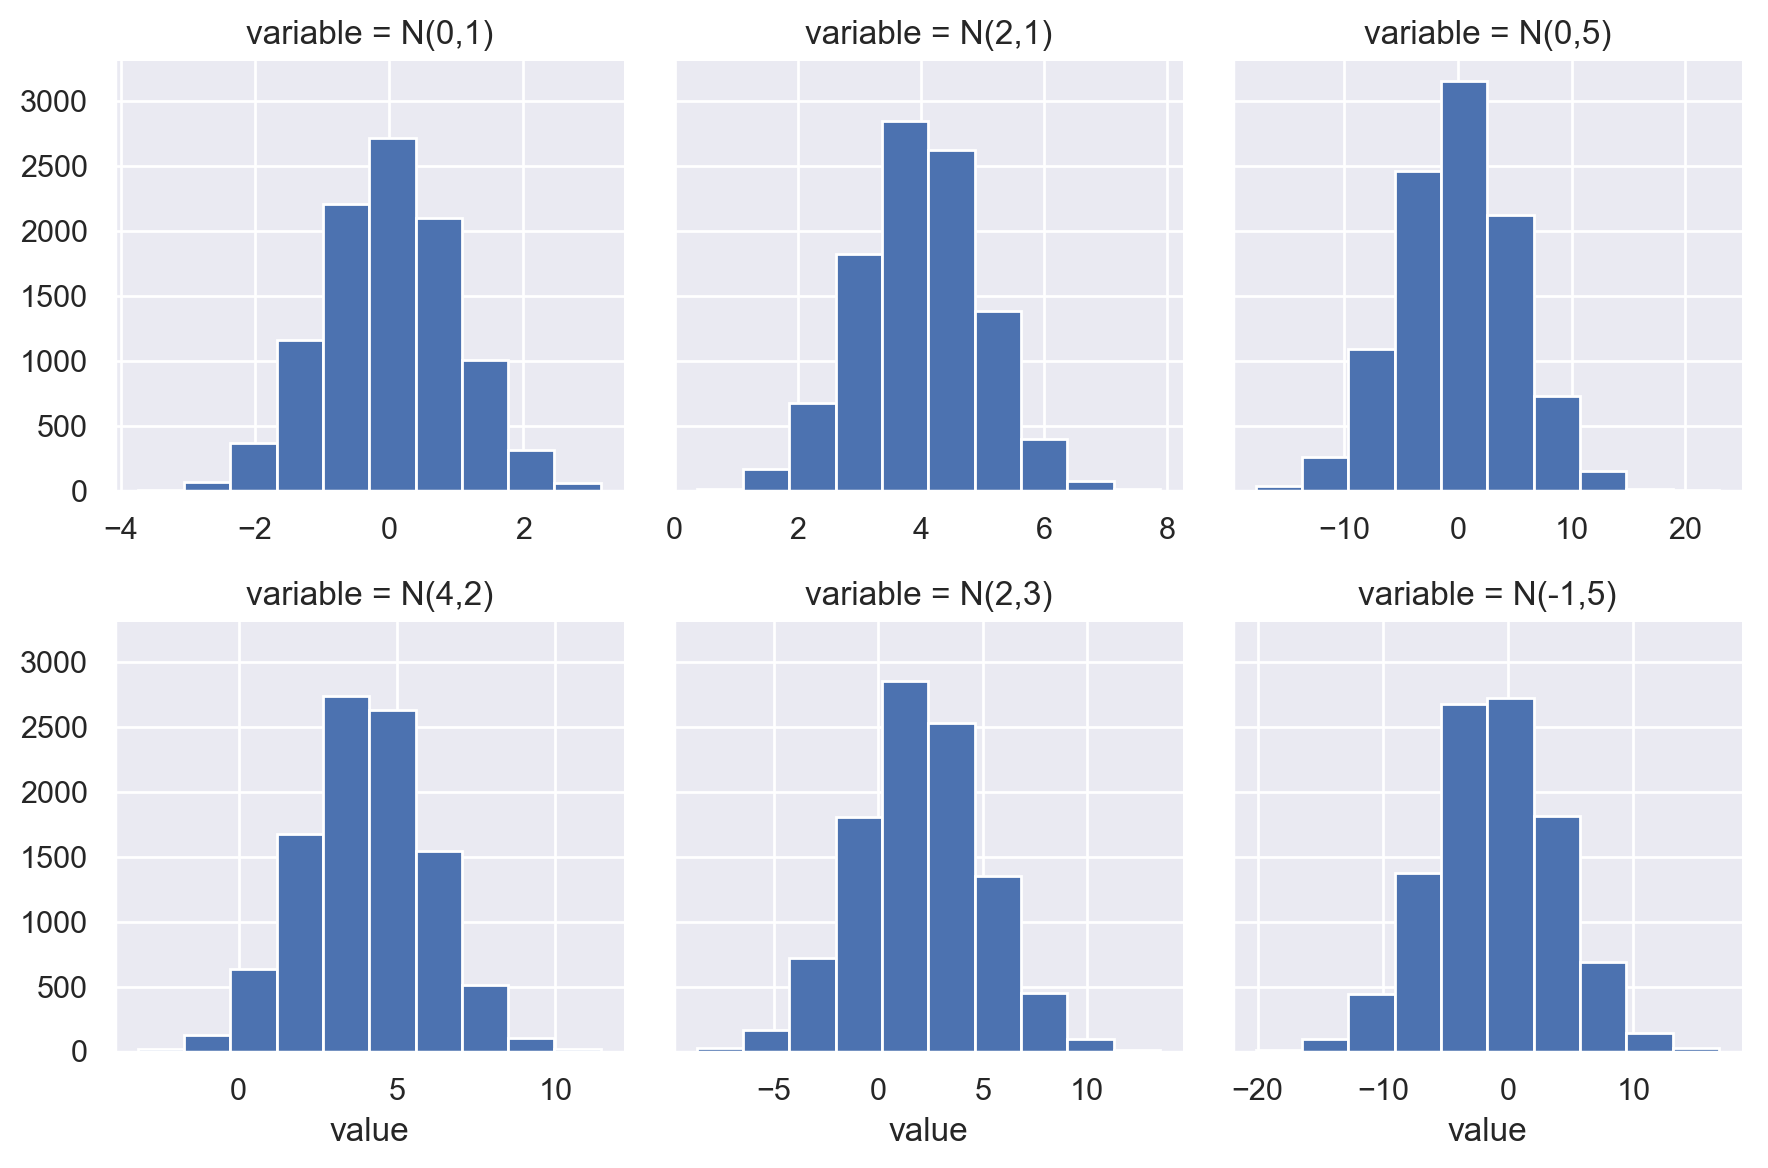

In [63]:
draw(data = df,bins = 10)

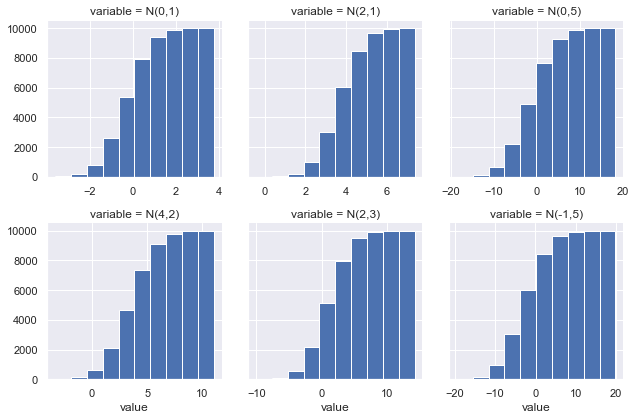

In [17]:
draw(data = df,bins = 10, _cumulative=True)

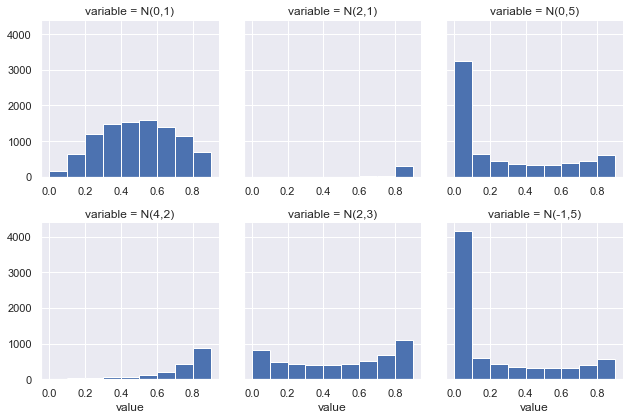

In [18]:
from scipy.special import expit

inv_df = expit(df.sample(size))
draw(inv_df,np.arange(0,1,0.1))

In [5]:
poisson_dict = {'poisson(1)': np.random.poisson( 1, size),'poisson(5)': np.random.poisson(5, size),'poisson(2)': np.random.poisson(2, size),
               'poisson(10)': np.random.poisson(10, size),'poisson(3.4)': np.random.poisson(3.4, size),'poisson(0.3)': np.random.poisson(0.3, size)}
poisson_df = pd.DataFrame(poisson_dict)
poisson_df.head(5)

,poisson(1),poisson(5),poisson(2),poisson(10),poisson(3.4),poisson(0.3)
0,1,8,0,10,4,1
1,2,7,0,10,6,1
2,1,10,0,8,3,1
3,0,4,3,8,2,0
4,1,3,2,6,2,0


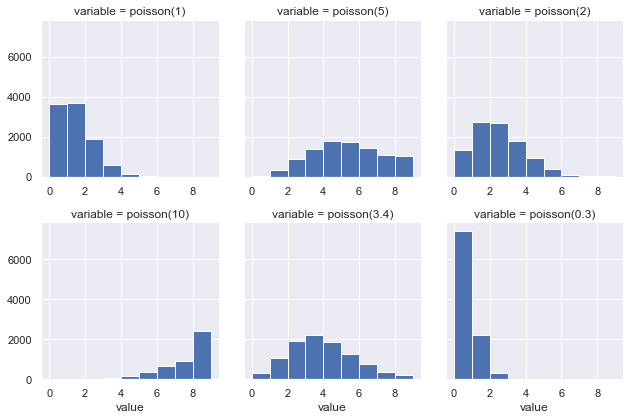

In [6]:
draw(poisson_df,bins = np.arange(0,10,1))

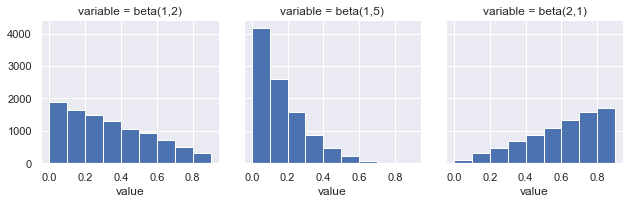

In [21]:
beta_dict = {'beta(1,2)': np.random.beta(1, 2, 10000),'beta(1,5)': np.random.beta(1,5, 10000),'beta(2,1)': np.random.beta(2, 1, 10000)}
beta_df = pd.DataFrame(beta_dict)
beta_df.head(5)
draw(beta_df,bins = np.arange(0,1,0.1))

In [22]:
def location(alpha, beta):
    return alpha / (alpha + beta)
def dispersion(alpha, beta):
    temp = location(alpha, beta)
    return temp * (1 - temp) * (1/(alpha + beta + 1))

def mean (alpha, beta):
    return alpha / (alpha + beta)
def population (alpha, beta):
    return (alpha + beta)

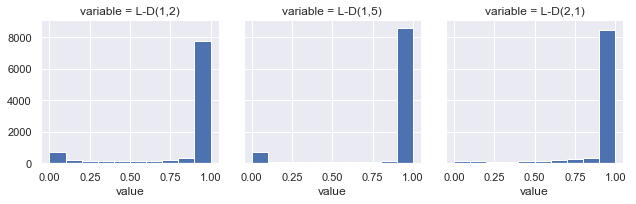

In [23]:
loc_dis = {
    'L-D(1,2)':np.random.beta(location(1,2), dispersion(1,2), size),
    'L-D(1,5)':np.random.beta(location(1,5), dispersion(1,5), size),
    'L-D(2,1)':np.random.beta(location(2,1), dispersion(2,1), size)}

loc_dis_df = pd.DataFrame(loc_dis)
draw(loc_dis_df, np.arange(0,1.1,0.1))

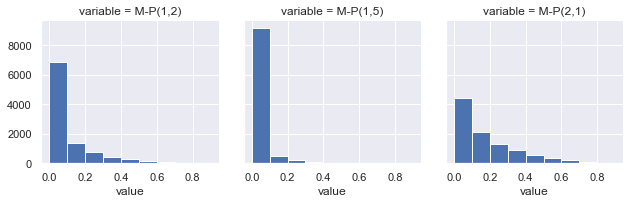

In [24]:
mean_pop = {
    'M-P(1,2)':np.random.beta(mean(1,2), population(1,2), size),
    'M-P(1,5)':np.random.beta(mean(1,5), population(1,5), size),
    'M-P(2,1)':np.random.beta(mean(2,1), population(2,1), size)}

mean_pop_df = pd.DataFrame(mean_pop)
draw(mean_pop_df, np.arange(0,1,0.1))

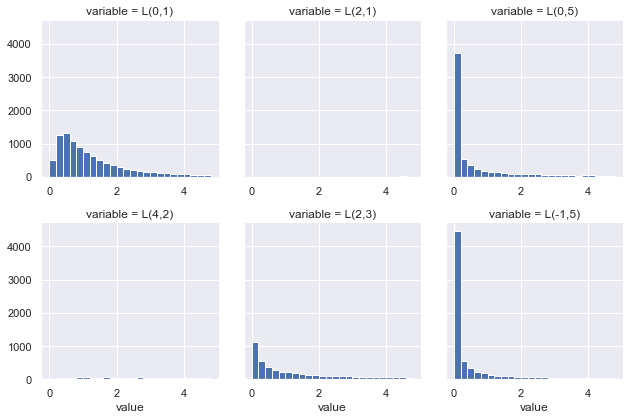

In [25]:
lognormal = {'L(0,1)':np.random.lognormal(0,1,size),'L(2,1)':np.random.lognormal(4,1,size),'L(0,5)':np.random.lognormal(0,5,size),
       'L(4,2)':np.random.lognormal(4,2,size),'L(2,3)':np.random.lognormal(2,3,size),'L(-1,5)':np.random.lognormal(-1,5,size)}

lognormal_df = pd.DataFrame(lognormal)
draw(lognormal_df, np.arange(0,5,0.2))

# Stan

In [2]:
import utilities.stan_utility as stan_utility
import pystan
import matplotlib as mpl

import scipy.stats as stats
from scipy.stats import kde


In [3]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


In [4]:
with open('stan/gamma.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real gamma = gamma_rng(alpha, beta);
    real inv_gamma = inv_gamma_rng(alpha, beta);
}


In [5]:
gamma_model = stan_utility.compile_model('stan/gamma.stan')

Using cached StanModel


In [6]:
sim = gamma_model.sampling(data={'alpha': 10, 'beta': 2},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [7]:
params=sim.extract()
gamma=params['gamma']
inv_gamma=params['inv_gamma']

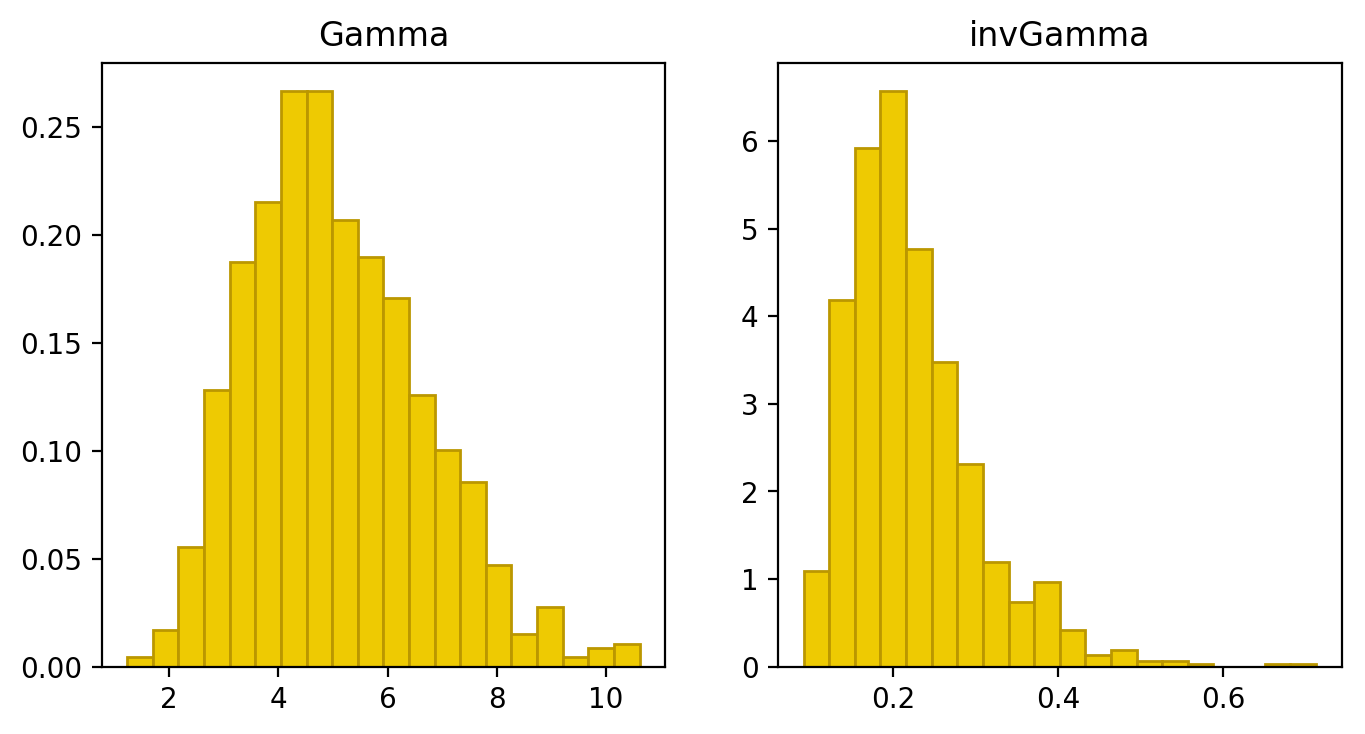

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,10,500)

ax2=axes[1]
ax2.hist(inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)

ax1.set_title('Gamma')
ax2.set_title('invGamma')
plt.show()

In [32]:
with open('stan/gamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector rightGamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        gammas[2] = gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        gammas[3] = exp(y[1])/exp(y[2]) - 7;
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}

transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(rightGamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}



In [33]:
gamma_tuning=stan_utility.compile_model('stan/gamma_tune.stan')

Using cached StanModel


In [36]:
data = dict(lowerBound =5 , upperBound=10, alphaGuess=10, betaGuess=2, probGuess=0.09) #  
tuned = gamma_tuning.sampling(data=data,
                                seed=28052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [37]:
alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 47.0	beta: 7.0


In [38]:
sim = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [39]:
with open('stan/invgamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector rightGamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] inv_gamma;
        inv_gamma[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        inv_gamma[2] = inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        inv_gamma[3] = exp(y[1])/exp(y[2]) - 7;
        return inv_gamma;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}

transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(rightGamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}



In [40]:
inv_gamma_tuning=stan_utility.compile_model('stan/invgamma_tune.stan')

Using cached StanModel


In [41]:
data = dict(lowerBound =5 , upperBound=10, alphaGuess=10, betaGuess=2, probGuess=0.09)
tuned = inv_gamma_tuning.sampling(data=data,
                                seed=28052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

RuntimeError: Exception: algebra_solver: the norm of the algebraic function is: 0.98009 but should be lower than the function tolerance: 1e-006. Consider decreasing the relative tolerance and increasing the max_num_steps.  (in 'unknown file name' at line 25)


In [104]:
alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 47.0	beta: 7.0


In [ ]:
sim_inv = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

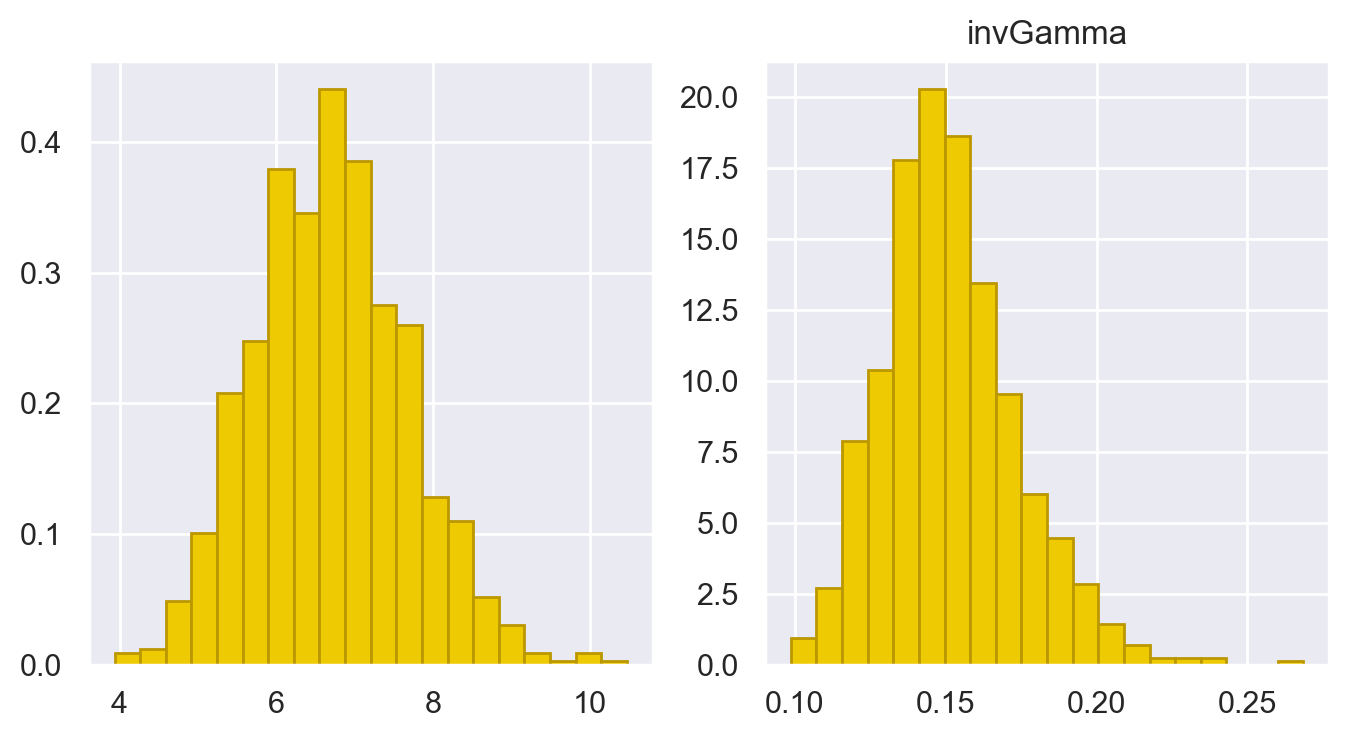

In [99]:
params=sim.extract()
gamma=params['gamma']

inv_params=inv_sim.extract()
inv_gamma=inv_params['inv_gamma']


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,10,500)

ax2=axes[1]
ax2.hist(inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)

ax2.set_title('invGamma')
plt.show()

In [42]:
with open('stan/negative.stan', 'r') as file:
    print(file.read())

negative_model = stan_utility.compile_model('stan/negative.stan')

data {
    real alpha;
    real mean_;
    real phi;
}

generated quantities {
    real neg_con = neg_binomial_rng(alpha, alpha/mean_);
    real neg_dis = neg_binomial_2_rng(mean_, phi);

    real poisson_con = poisson_rng(mean_);
}



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4c27b0e4c37367e5cf8398a65dcd455 NOW.


In [43]:
data = dict(mean_=10, alpha=2, phi=2) 
negative_sampled = negative_model.sampling(data=data,
                                            seed=25052020,
                                            algorithm="Fixed_param",
                                            iter=1000, 
                                            warmup=0,
                                            chains=1)

In [44]:
params=negative_sampled.extract()
neg_bin_con=params['neg_con']
poisson_con=params['poisson_con']
neg_bin_dis=params['neg_dis']

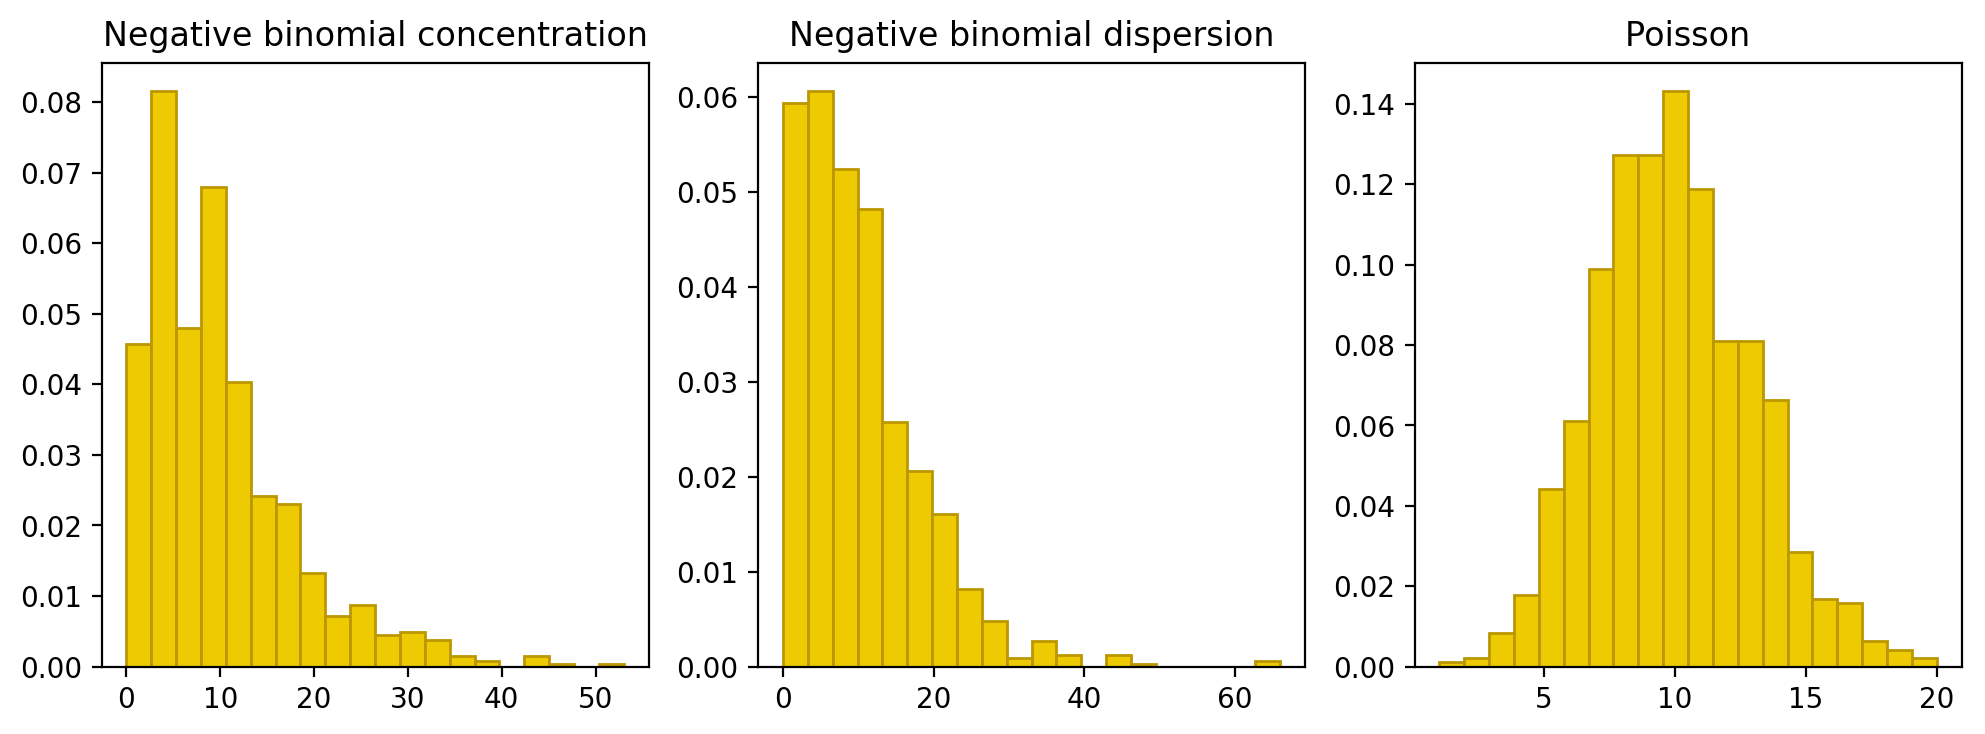

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax1=axes[0]
ax1.hist(neg_bin_con,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.set_title(r'Negative binomial concentration')

ax3=axes[1]
ax3.hist(neg_bin_dis,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax3.set_title(r'Negative binomial dispersion')

ax2=axes[2]
ax2.hist(poisson_con,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Poisson')

plt.show()

In [50]:
with open('stan/student_t.stan', 'r') as file:
    print(file.read())
student_t = stan_utility.compile_model('stan/student_t.stan')

data {
    real nu;    //degrees of freedom
    real mu;    //location
    real sigma; //scale
}

generated quantities {
    real y_sim = student_t_rng(nu, mu, sigma);
}


Using cached StanModel


In [82]:
sim_1=student_t.sampling(data={'nu':5, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=25052020)
sim_2=student_t.sampling(data={'nu':5, 'mu':1, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=1000, 
                      warmup=0, 
                      chains=1,
                      seed=25052020)
sim_cauchy=student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=100, 
                      warmup=0, 
                      chains=1,
                      seed=25052020)

In [83]:
params1=sim_1.extract()
student1=params1['y_sim']

params2=sim_2.extract()
student2=params2['y_sim']

params3=sim_cauchy.extract()
student3=params3['y_sim']

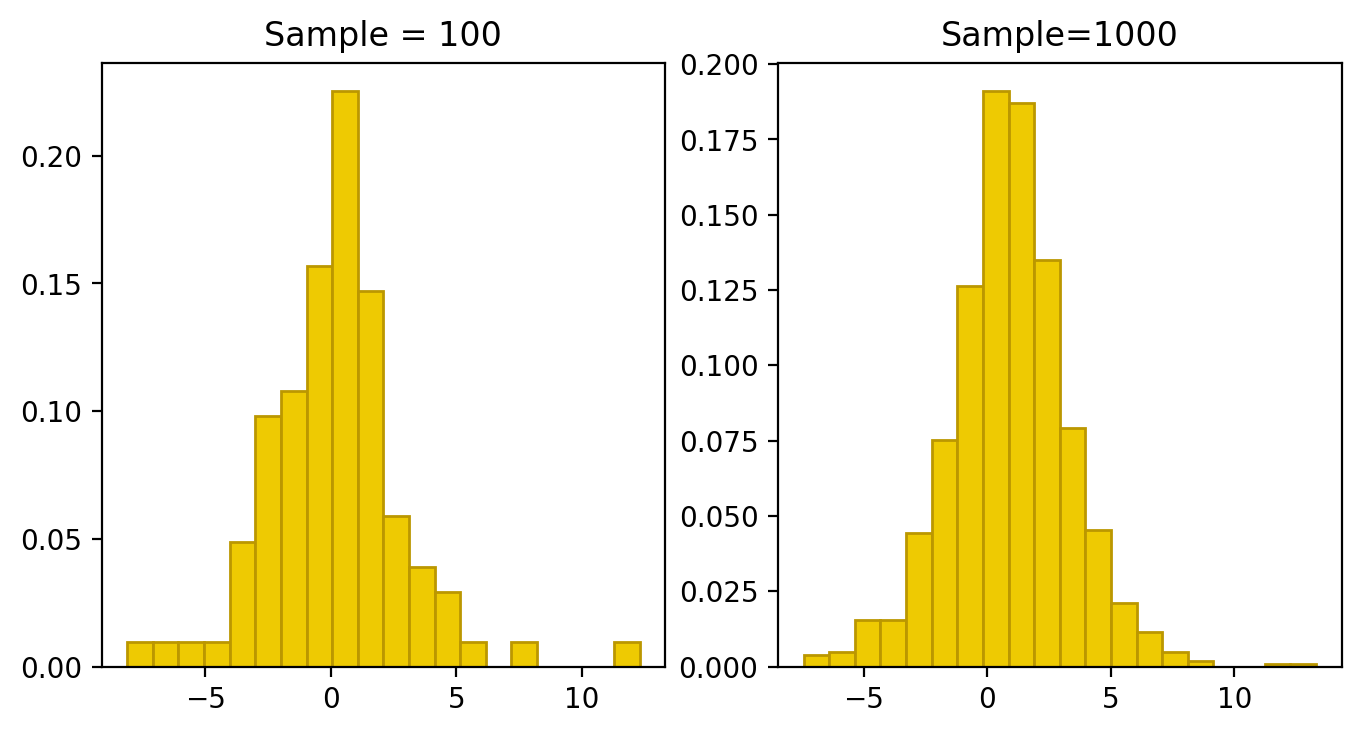

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'Sample = 100')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'Sample=1000')

plt.show()

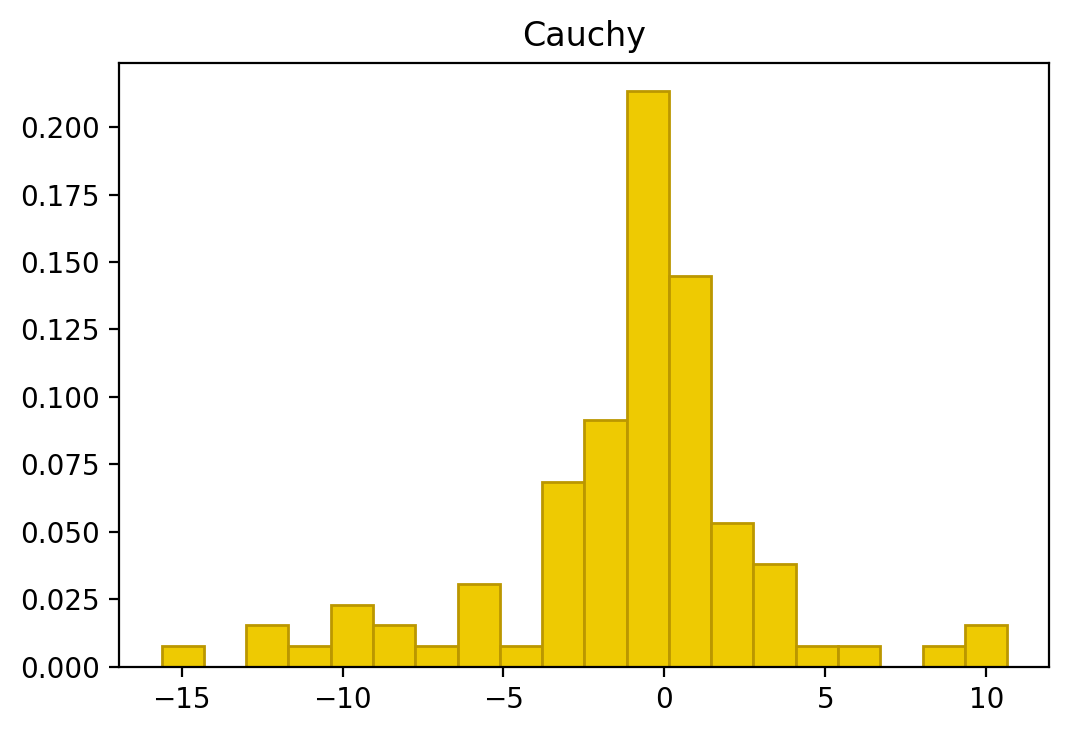

In [75]:
plt.title('Cauchy',x= 0.5,y=1, fontsize=12)
plt.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)

plt.show()

In [79]:
print(np.median(student1),
np.median(student2),
np.var(student1),
np.var(student2))



-0.5803838598352855 0.9876861845469028 16.867715824764232 29.071910900783738


In [85]:
with open('stan/normal.stan') as file:
    print(file.read())
normal = stan_utility.compile_model('stan/normal.stan')

data {
    vector[2] mu;       // location
    matrix[2,2] sigma;  // scale
}


generated quantities {
    vector[2] result = multi_normal_rng(mu,sigma);
}

Using cached StanModel


In [105]:
data = dict(mu=[2, 1], sigma=[[1, 0.5],[0.5, 2]])
normal = normal.sampling(data=data,
                                seed=2852020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)
normal = normal.extract()
y_sim = normal['result'].T

In [106]:
y_sim0 = y_sim[0].flatten()
y_sim1 = y_sim[1].flatten()

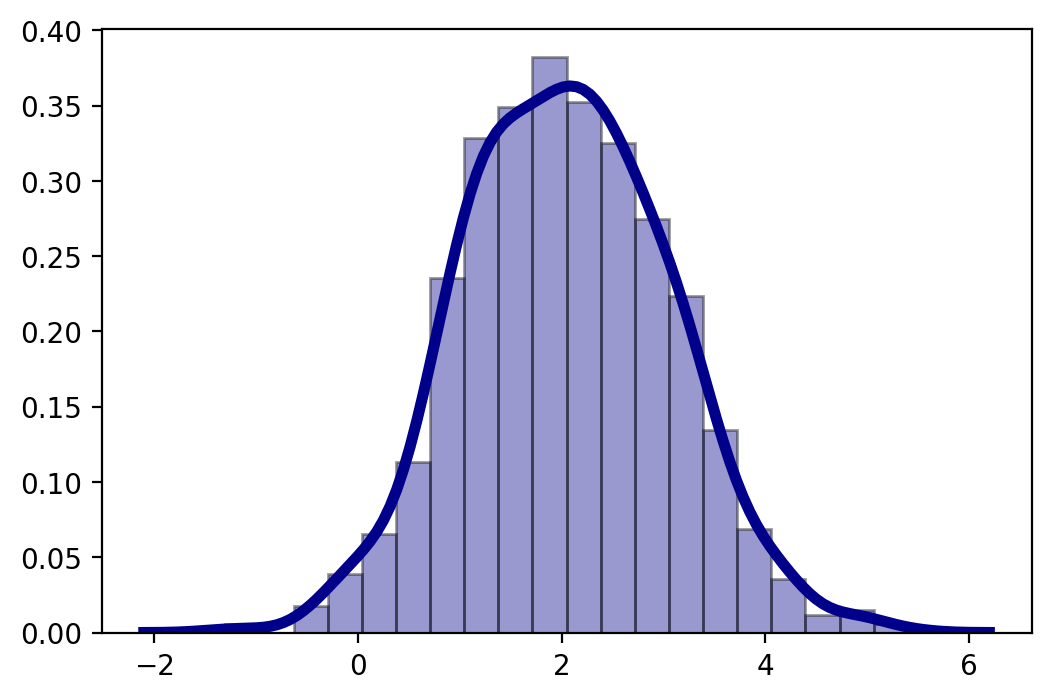

In [107]:
# Density Plot and Histogram of all arrival delays
sns.distplot(y_sim[0].flatten(), hist=True, kde=True, 
             bins=20, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [108]:
to_df = np.array([y_sim0, y_sim1]).T
df = pd.DataFrame(to_df, columns=["normal1", "normal2"])

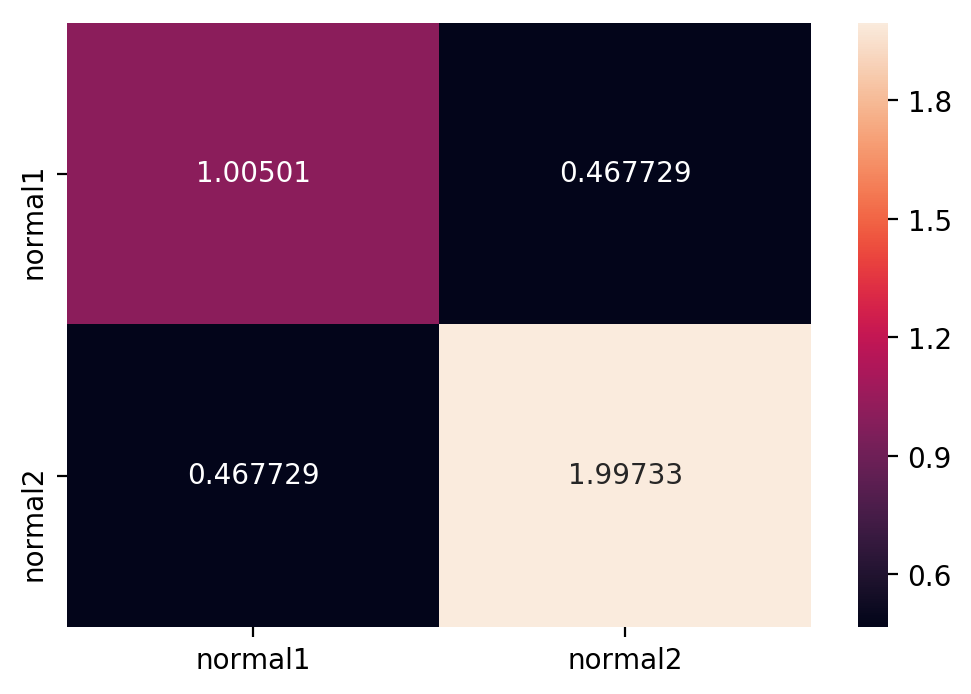

In [109]:
covMatrix = pd.DataFrame.cov(df)
sns.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

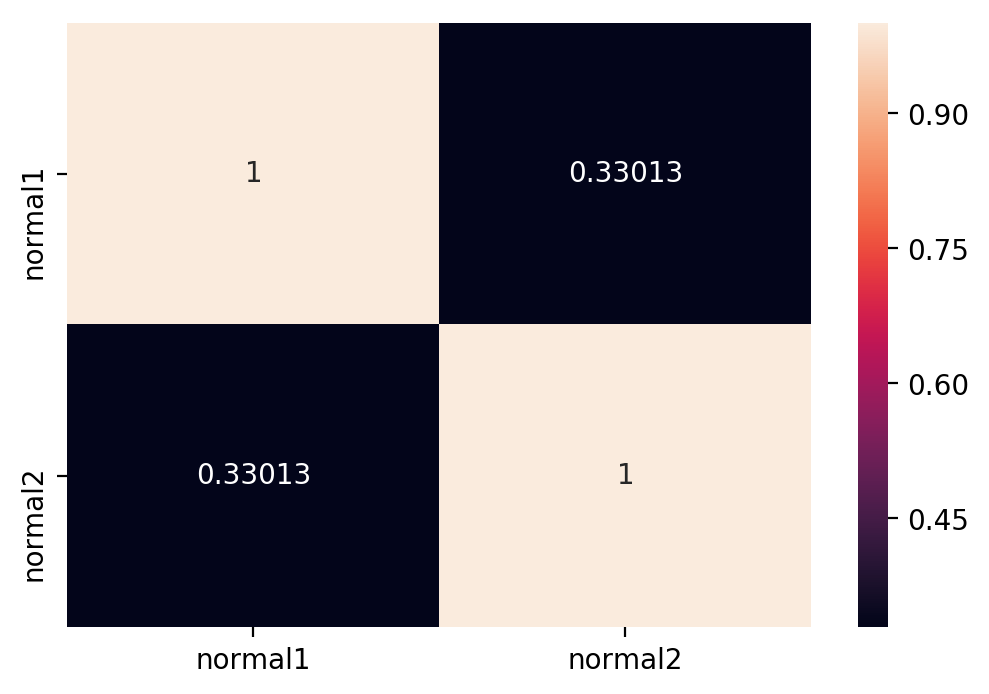

In [119]:
corrMatrix = pd.DataFrame.corr(df)
sns.heatmap(corrMatrix, annot=True, fmt='g')
plt.show()

In [120]:
with open('stan/normal3.stan', 'r') as file:
    print(file.read())
normal_3 = stan_utility.compile_model('stan/normal3.stan')

data {
    vector[3] mu;       // location
    matrix[3,3] sigma;  // scale
}


generated quantities {
    vector[3] result = multi_normal_rng(mu,sigma);
}



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_663f286b80b2c56f24e2355209441ebb NOW.


In [128]:
mu = [2, 8, 12]
sigma = [[1, 0.3, 0.2], [0.3, 2, 0.3],[0.2, 0.3, 2]]

In [129]:
R1=100
sim_3=normal_3.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=28052020)

In [131]:
params1 = sim_3.extract()
result = params1['result']
result = result.T

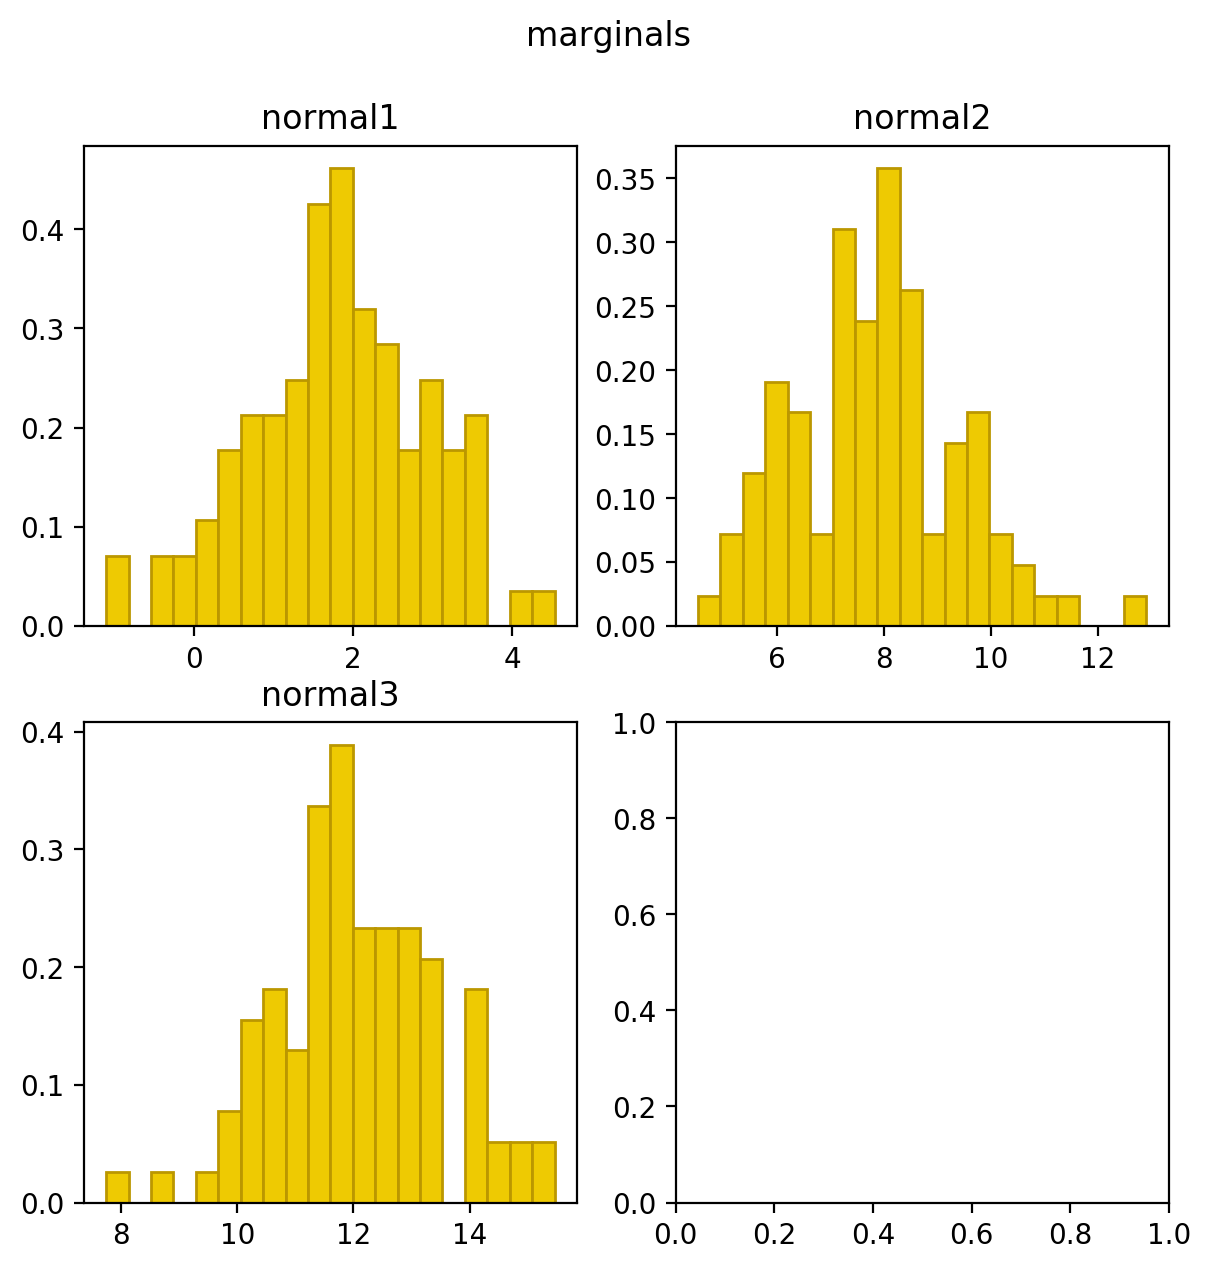

In [133]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('marginals',x= 0.5,y=0.97, fontsize=12)

ax1=axes[0][0]
ax1.hist(result[0],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')


plt.show()


In [134]:
with open('stan/normal4.stan', 'r') as file:
    print(file.read())
normal_4 = stan_utility.compile_model('stan/normal4.stan')

data {
    vector[4] mu;       // location
    matrix[4,4] sigma;  // scale
}


generated quantities {
    vector[4] result = multi_normal_rng(mu,sigma);
}

Using cached StanModel


In [135]:
mu = [2, 8, 2, 8]
sigma = [[1, 0.3, 0.2,0.1], [0.3, 2, 0.3,0.1],[0.2, 0.3, 2,0.1],[0.1,0.1,0.1,1]]

In [136]:
R1=100
sim_4=normal_4.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=28052020)

In [137]:
params1 = sim_4.extract()
result = params1['result']
result = result.T

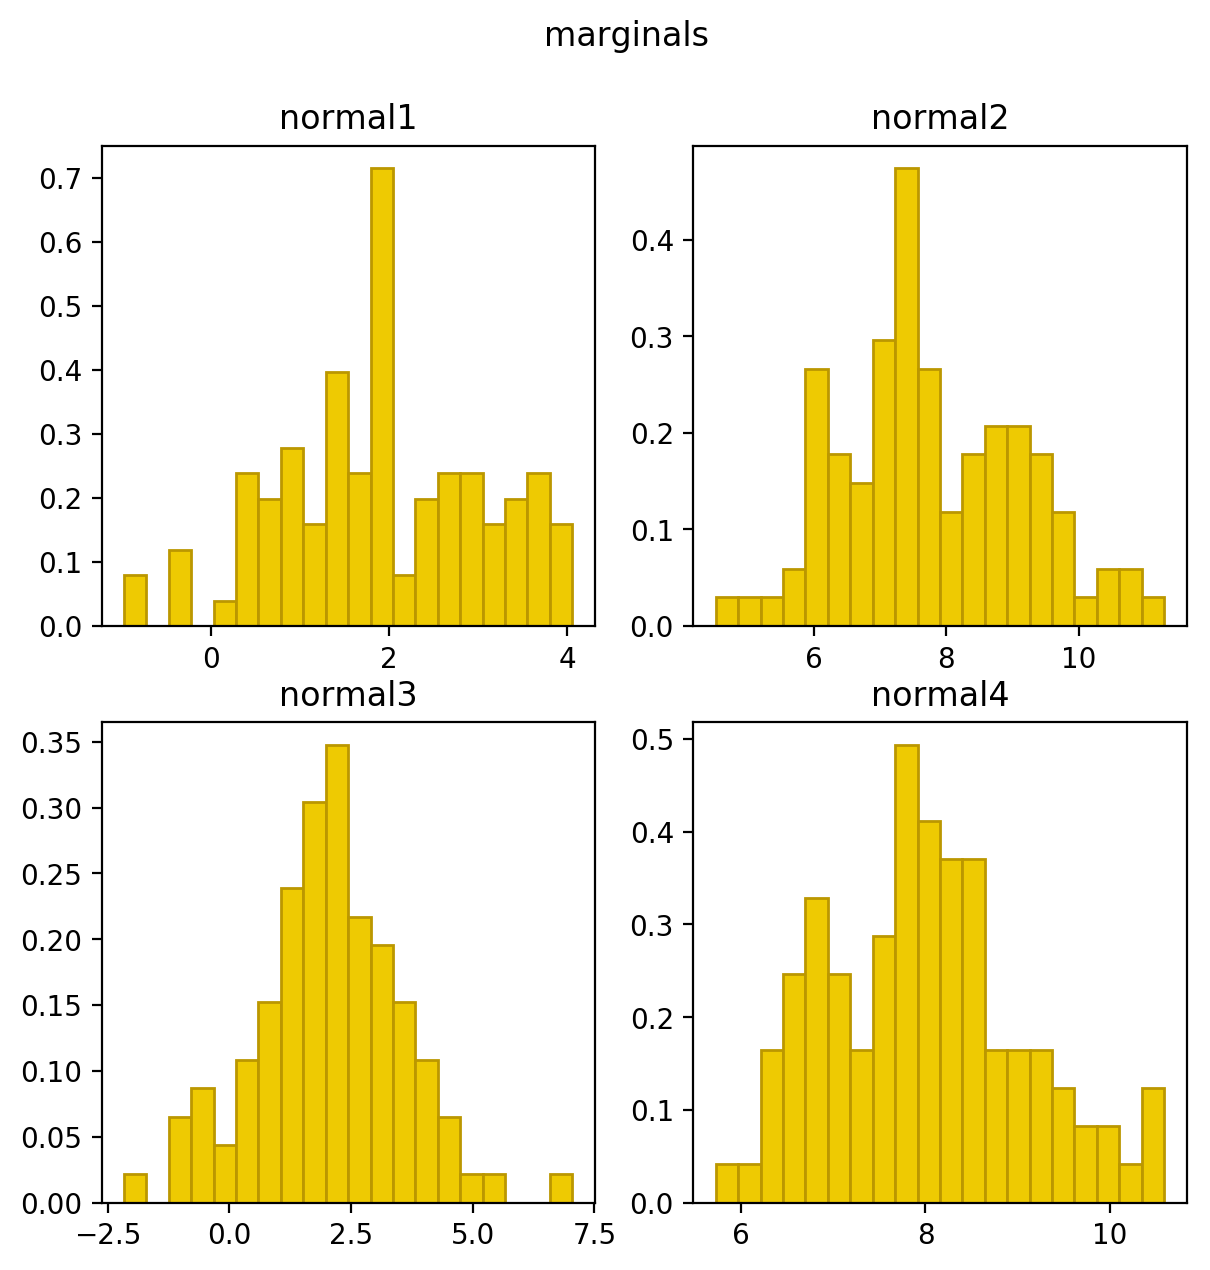

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('marginals',x= 0.5,y=0.97, fontsize=12)

ax1=axes[0][0]
ax1.hist(result[0],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')

ax2=axes[1][1]
ax2.hist(result[3],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal4')

plt.show()
